(how-to-ts)=
# ...handle time series data?

## Import packages

In [ ]:
%matplotlib inline

import spyndex
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sdc.load import load_product
from sdc.utils import groupby_acq_slices

## Loading data

In [ ]:
vec = '../../_assets/vec_01_05_01.geojson'
ds = load_product(product="s2_l2a", vec=vec)
ds = groupby_acq_slices(ds)

params = {'N': ds.B08, 'R': ds.B04, 'B': ds.B02, 'g': 2.5, 'C1': 6.0, 'C2': 7.5, 'L': 1.0}
evi = spyndex.computeIndex(index=['EVI'], params=params)
evi

<xarray.DataArray (time: 523, latitude: 131, longitude: 147)> Size: 40MB
dask.array<truediv, shape=(523, 131, 147), dtype=float32, chunksize=(523, 131, 147), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 4kB 2018-01-04T08:00:00 ... 2025-03-30...
  * latitude     (latitude) float64 1kB -25.06 -25.06 -25.06 ... -25.08 -25.08
  * longitude    (longitude) float64 1kB 31.47 31.47 31.47 ... 31.5 31.5 31.5
    spatial_ref  int32 4B 4326
Attributes:
    nodata:   0

## Data exploration

This example area is small and relatively homogeneous, so we can spatially average the EVI values to get a single time series:

In [408]:
evi_sm = evi.mean(dim=['longitude', 'latitude'])
evi_sm

<xarray.DataArray (time: 523)> Size: 2kB
dask.array<mean_agg-aggregate, shape=(523,), dtype=float32, chunksize=(523,), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 4kB 2018-01-04T08:00:00 ... 2025-03-30...
    spatial_ref  int32 4B 4326
Attributes:
    nodata:   0

The `.plot()`-method automatically creates a line plot, which is not ideal when nodata values and outliers are present. Better to use a scatter plot:

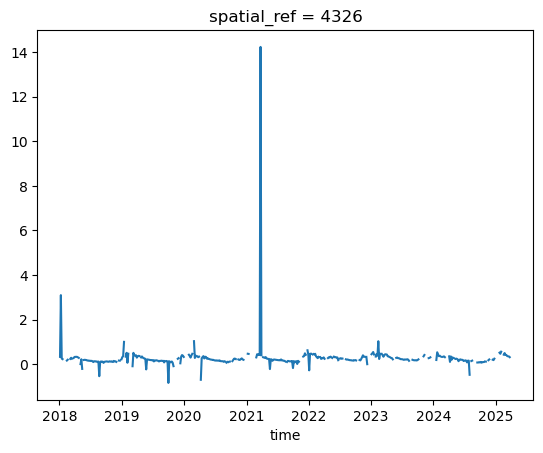

In [409]:
evi_sm.plot()

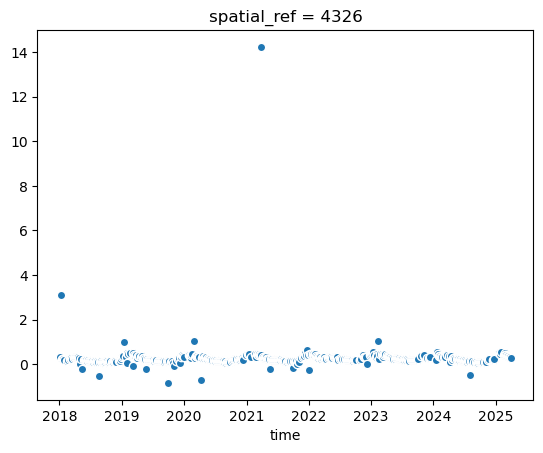

In [410]:
evi_sm.plot.scatter(x='time') # x-axis has to be specified!

Let's compute values so that we don't have to re-compute everytime we want to access them (e.g. for plotting). We then convert the xarray DataArray to a pandas DataFrame for easier handling in the following steps:

In [ ]:
vi_sm = evi_sm.compute()
evi_sm

In [ ]:
evi_sm_df = evi_sm.to_series()
evi_sm_df

time
2018-01-04 08:00:00    0.331300
2018-01-09 08:00:00    3.099223
2018-01-14 08:00:00    0.252956
2018-01-19 08:00:00    0.228773
2018-01-24 08:00:00         NaN
                         ...   
2025-03-13 08:00:00    0.355623
2025-03-20 08:00:00    0.342944
2025-03-23 08:00:00    0.316812
2025-03-28 08:00:00         NaN
2025-03-30 08:00:00    0.263662
Length: 523, dtype: float32

In [147]:
# Easy to get some summary statistics with pandas

print("Total count:", len(evi_sm_df))
print("Nodata count:", evi_sm_df.isna().sum())
evi_sm_df.describe()

Total count: 523
Nodata count: 108


count    415.000000
mean       0.277122
std        0.720414
min       -0.837399
25%        0.154266
50%        0.219401
75%        0.329128
max       14.230196
dtype: float64

The library `seaborn` integrates well with matplotlib to create attractive statistical plots. We will use it from here on to create scatter plots of our time series data. 

<Axes: xlabel='time'>

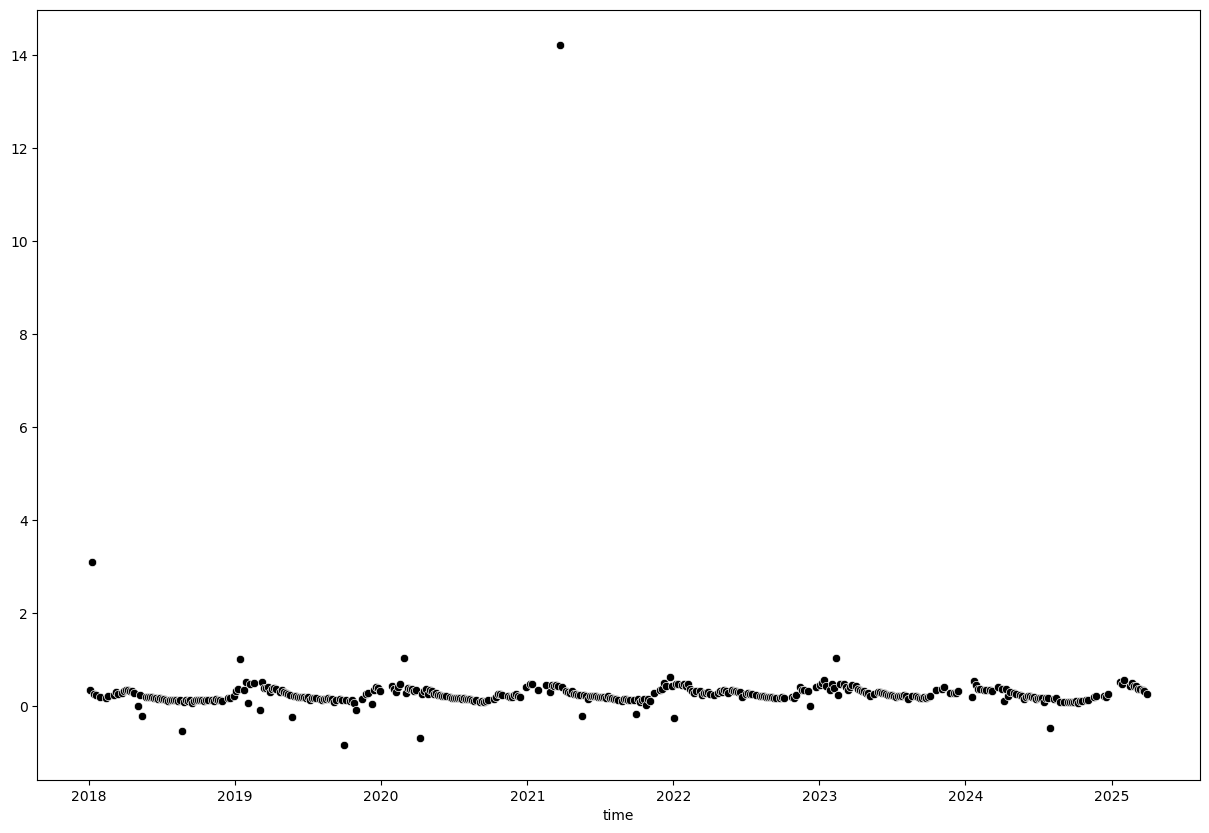

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=evi_sm_df.index, y=evi_sm_df.values, color='black')

We can see a few extreme outliers. Let's limit y-axis to valid EVI range to better visualize the data:

(-1.0, 1.0)

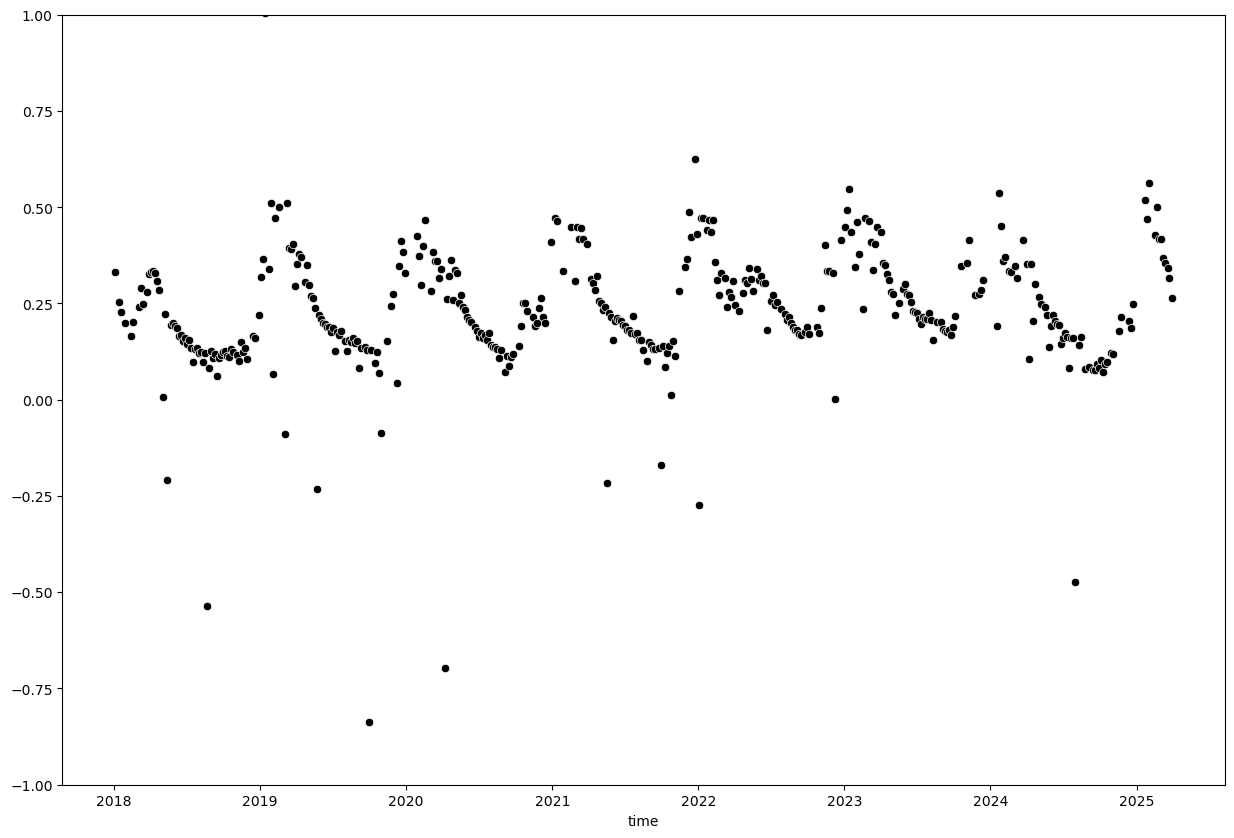

In [411]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=evi_sm_df.index, y=evi_sm_df.values, color='black')
plt.ylim(-1, 1)

## Outlier removal

A simple threshold of 0 - 1 will not exclude all outliers but is a good starting point. Be careful with thresholding as you might exclude valid data points as well.

In [ ]:
evi_sm_df_01 = evi_sm_df[(evi_sm_df >= 0) & (evi_sm_df <= 1)]

<Axes: xlabel='time'>

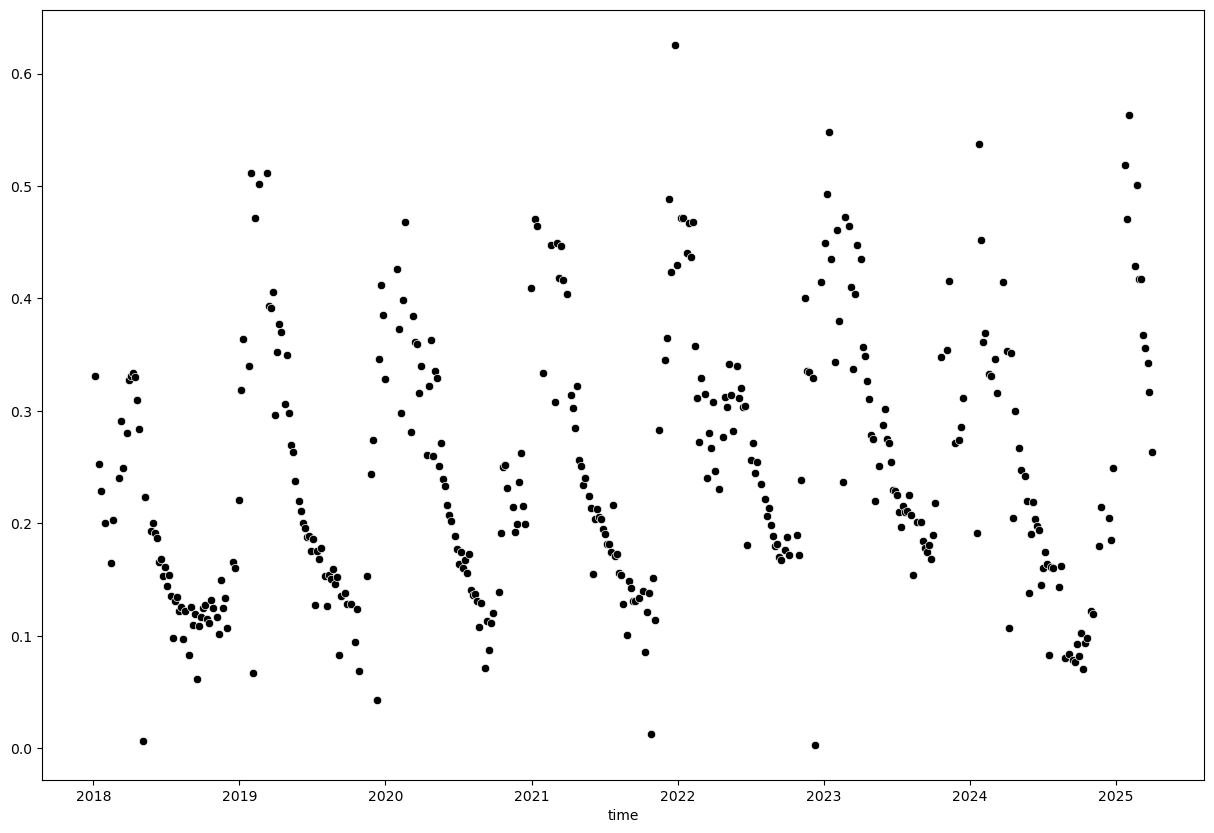

In [163]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=evi_sm_df_01.index, y=evi_sm_df_01.values, color='black')

Instead of using a simple threshold, we can also use statistical methods to identify outliers. For example, we can use the z-score method to identify points that are a certain number of standard deviations away from the mean.

<Axes: xlabel='time'>

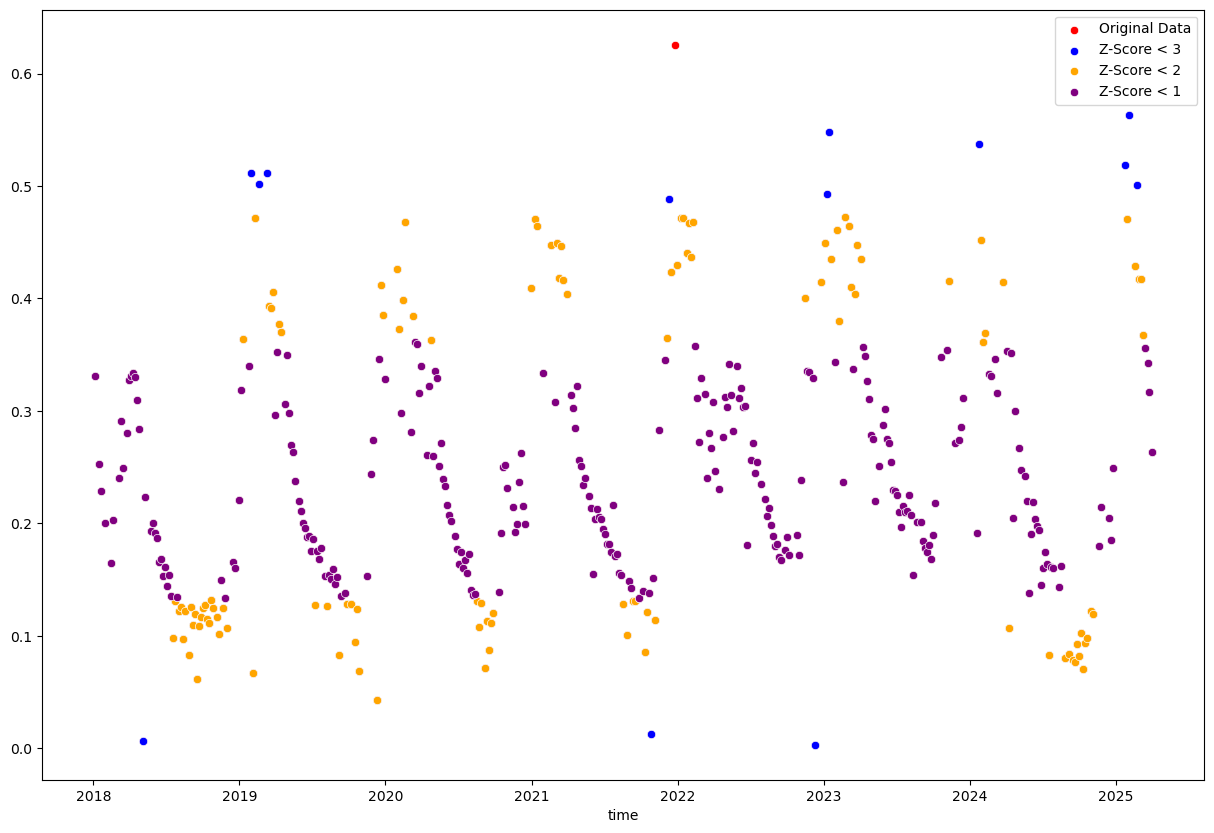

In [ ]:
from scipy.stats import zscore

z_scores = np.abs(zscore(evi_sm_df_01.values, nan_policy='omit'))
z_score_flt3 = z_scores < 3  # Flag all values with z-score < 3 as True, others as False
z_score_flt2 = z_scores < 2
z_score_flt1 = z_scores < 1

plt.figure(figsize=(15, 10))
sns.scatterplot(x=evi_sm_df_01.index, y=evi_sm_df_01.values, color='red', label='Original Data')
sns.scatterplot(x=evi_sm_df_01[z_score_flt3].index, y=evi_sm_df_01[z_score_flt3].values, color='blue', label='Z-Score < 3')
sns.scatterplot(x=evi_sm_df_01[z_score_flt2].index, y=evi_sm_df_01[z_score_flt2].values, color='orange', label='Z-Score < 2')
sns.scatterplot(x=evi_sm_df_01[z_score_flt1].index, y=evi_sm_df_01[z_score_flt1].values, color='purple', label='Z-Score < 1')

The single "Original Data" point is filtered out by all three z-score filters. The other colored points are the ones that remain after applying the respective z-score filters, with more points being filtered out as the threshold becomes stricter.

The stricter thresholds remove too many valid data points because it is applied to the entire dataset without considering temporal context. The z-score is calculated based on the mean and standard deviation of the entire dataset and assumes a normal distribution of values. In datasets with high variability or seasonal patterns, many valid points will be incorrectly flagged as outliers. 

<Axes: xlabel='time'>

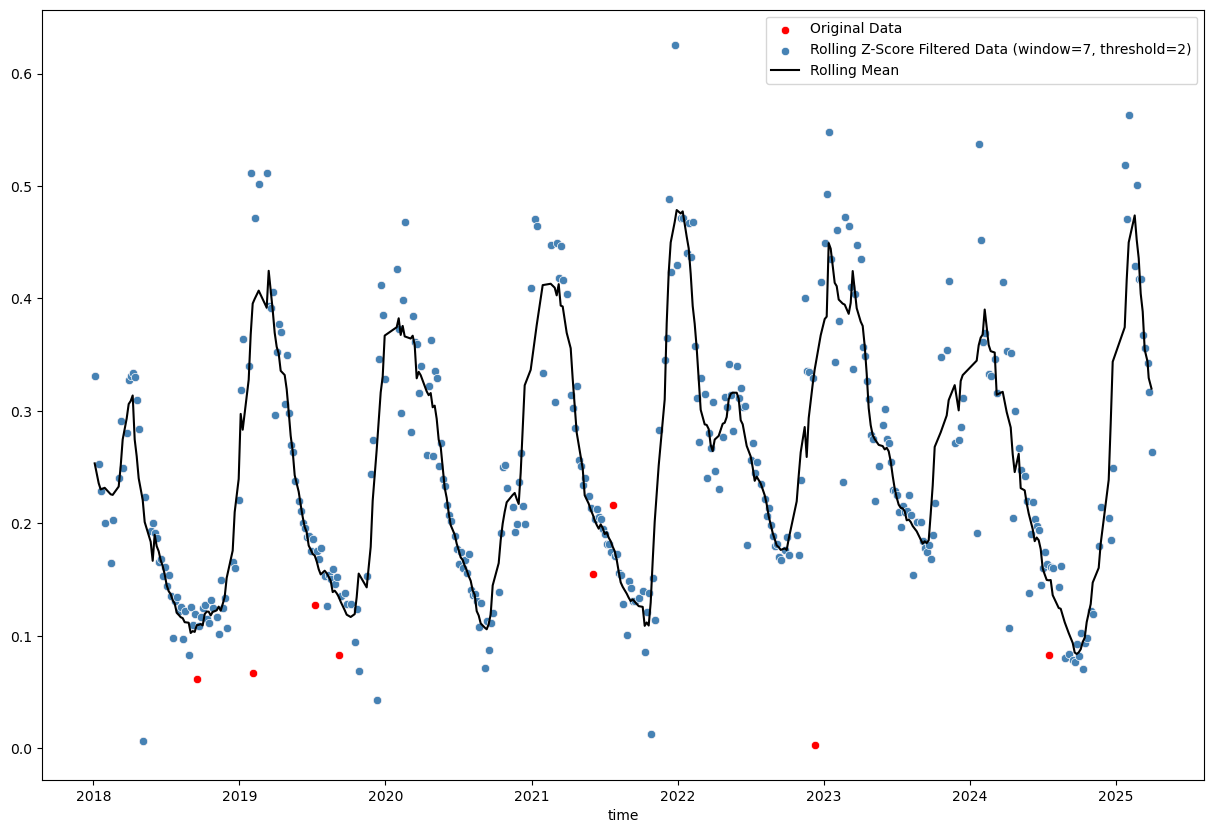

In [296]:
# Calculate rolling z-score
window_size = 7
rolling_mean = evi_sm_df_01.rolling(window=window_size, center=True, min_periods=(window_size//2)).mean() # use min_periods to avoid NaNs at start and end
rolling_std = evi_sm_df_01.rolling(window=window_size, center=True, min_periods=(window_size//2)).std()
z_score_rolling = (evi_sm_df_01 - rolling_mean) / rolling_std

# Identify outliers
threshold = 2
outliers_rolling = np.abs(z_score_rolling) < threshold

plt.figure(figsize=(15, 10))
sns.scatterplot(x=evi_sm_df_01.index, y=evi_sm_df_01.values, color='red', label='Original Data')
sns.scatterplot(x=evi_sm_df_01[outliers_rolling].index, y=evi_sm_df_01[outliers_rolling].values, color='steelblue', label=f'Rolling Z-Score Filtered Data (window={window_size}, threshold={threshold})')
sns.lineplot(x=rolling_mean.index, y=rolling_mean.values, color='black', label='Rolling Mean')

<Axes: xlabel='time'>

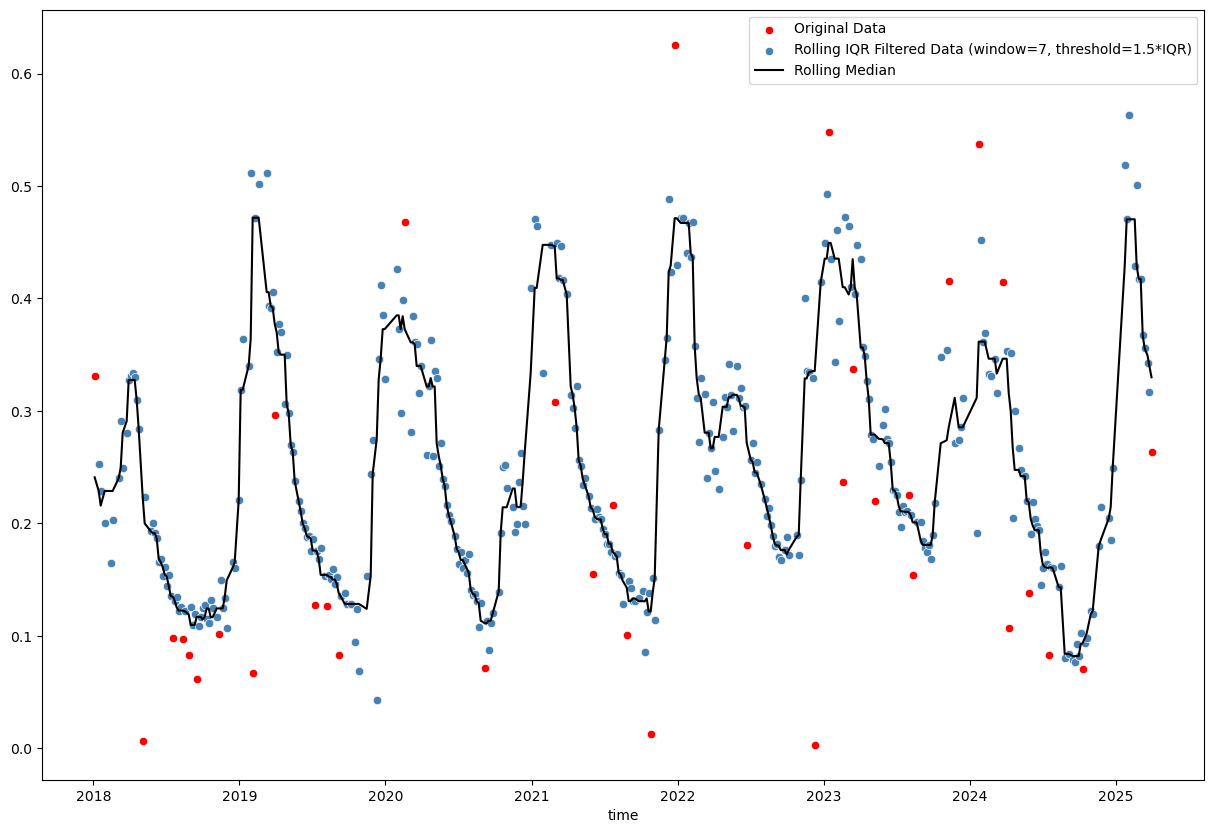

In [297]:
# Rolling IQR method
window_size = 7
rolling_median = evi_sm_df_01.rolling(window=window_size, center=True, min_periods=(window_size//2)).median()
rolling_q75 = evi_sm_df_01.rolling(window=window_size, center=True, min_periods=(window_size//2)).quantile(0.75)
rolling_q25 = evi_sm_df_01.rolling(window=window_size, center=True, min_periods=(window_size//2)).quantile(0.25)
rolling_iqr = rolling_q75 - rolling_q25

# Identify outliers (1.5 * IQR is standard, but can adjust)
threshold_iqr = 1.5
lower_bound = rolling_median - threshold_iqr * rolling_iqr
upper_bound = rolling_median + threshold_iqr * rolling_iqr
outliers_iqr = (evi_sm_df_01 >= lower_bound) & (evi_sm_df_01 <= upper_bound)

plt.figure(figsize=(15, 10))
sns.scatterplot(x=evi_sm_df_01.index, y=evi_sm_df_01.values, color='red', label='Original Data')
sns.scatterplot(x=evi_sm_df_01[outliers_iqr].index, y=evi_sm_df_01[outliers_iqr].values, color='steelblue', label=f'Rolling IQR Filtered Data (window={window_size}, threshold={threshold_iqr}*IQR)')
sns.lineplot(x=rolling_median.index, y=rolling_median.values, color='black', label='Rolling Median')


Basic rolling z-score (using mean and standard deviation) and interquartile range (IQR; using median and quartiles) methods are tricky, because choosing the right window size and threshold is not straightforward. Furthermore, even a reasonable choice of these parameters may not yield satisfactory results, especially in the presence of seasonal patterns or trends in the data (as we can see in the plots above).

When googling "python outlier detection", we end up on [this](https://scikit-learn.org/stable/modules/outlier_detection.html) page from the `scikit-learn` documentation, which introduces the [Local Outlier Factor (LOF)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) and [Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) methods for outlier detection. These methods are more sophisticated and can handle complex data patterns better than simple rolling statistics. Let's try them out!

<Axes: xlabel='time'>

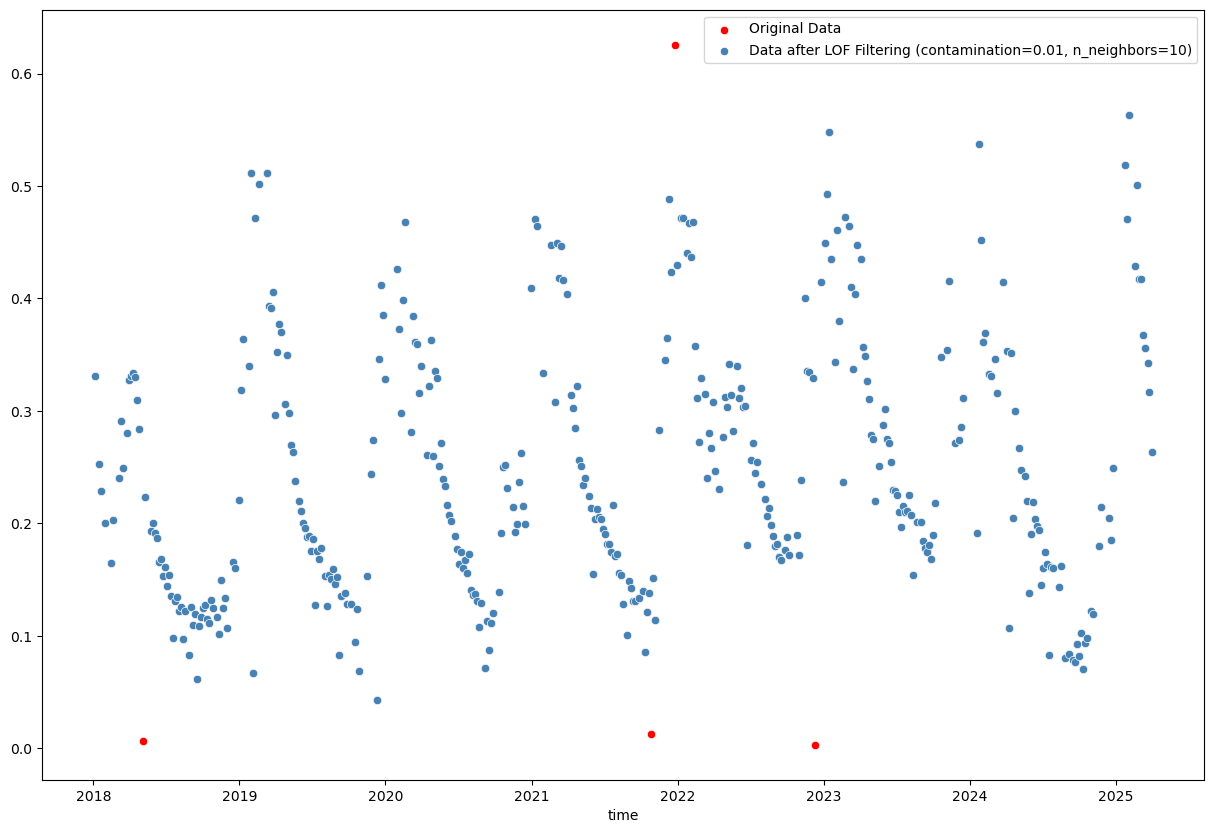

In [301]:
from sklearn.neighbors import LocalOutlierFactor

contamination = 0.01
n_neighbors = 10
# Experiment with these parameters to see how they affect the results. `contamination` defines the proportion of outliers in the data set and should be set according to your knowledge of the data (e.g., 0.01 for 1% outliers). 
# `n_neighbors` defines the number of neighbors to use for the LOF algorithm and can affect sensitivity to local data structure (default is 20).
lof = LocalOutlierFactor(contamination=contamination, n_neighbors=n_neighbors)
lof_fit = lof.fit_predict(evi_sm_df_01.values.reshape(-1, 1))
lof_flt = lof_fit == 1  # In LOF, -1 indicates an outlier, 1 indicates an inlier

plt.figure(figsize=(15, 10))
sns.scatterplot(x=evi_sm_df_01.index, y=evi_sm_df_01.values, color='red', label='Original Data')
sns.scatterplot(x=evi_sm_df_01[lof_flt].index, y=evi_sm_df_01[lof_flt].values, color='steelblue', label=f'Data after LOF Filtering (contamination={contamination}, n_neighbors={n_neighbors})')

<Axes: xlabel='time'>

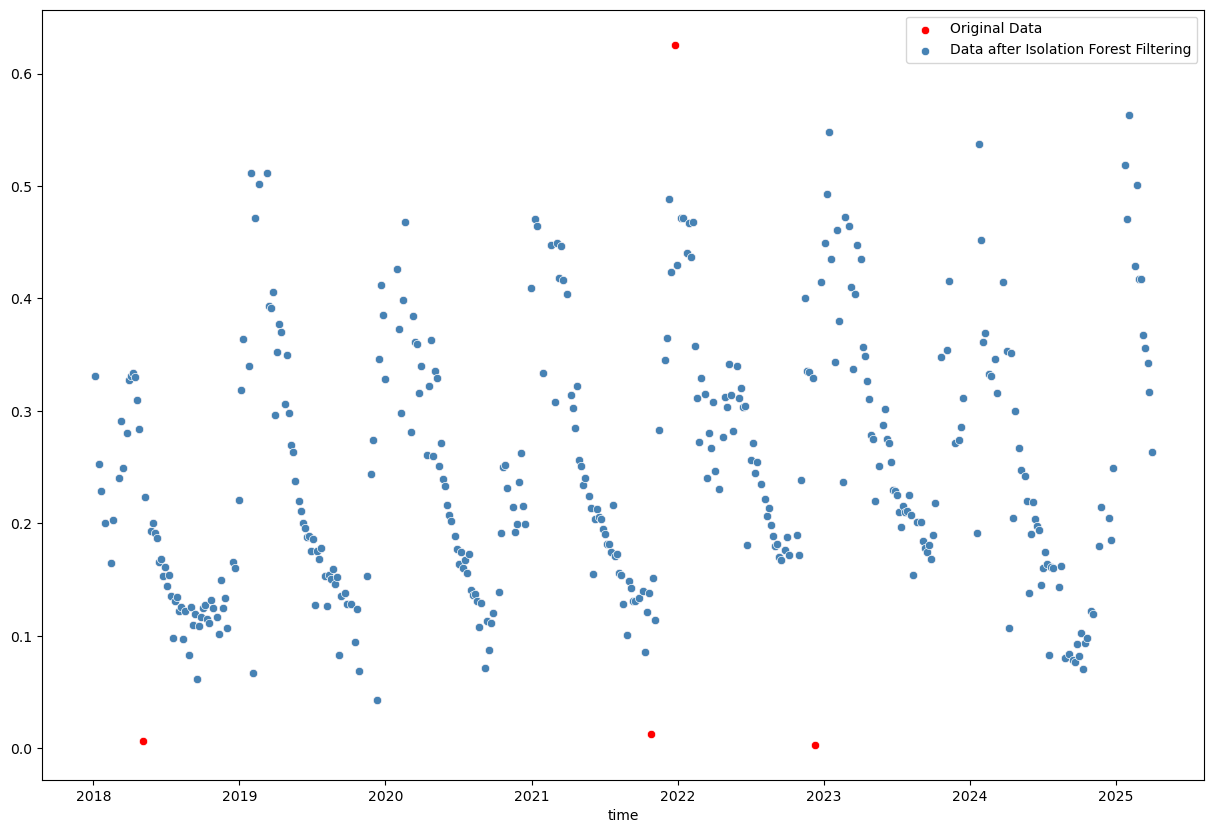

In [304]:
from sklearn.ensemble import IsolationForest

contamination = 0.01
# Similarly, you can experiment with the `contamination` parameter here.
iso_forest = IsolationForest(contamination=contamination)
iso_fit = iso_forest.fit_predict(evi_sm_df_01.values.reshape(-1, 1))
iso_flt = iso_fit == 1  # In Isolation Forest, -1 indicates an outlier, 1 indicates an inlier  

plt.figure(figsize=(15, 10))
sns.scatterplot(x=evi_sm_df_01.index, y=evi_sm_df_01.values, color='red', label='Original Data')
sns.scatterplot(x=evi_sm_df_01[iso_flt].index, y=evi_sm_df_01[iso_flt].values, color='steelblue', label='Data after Isolation Forest Filtering')

The Isolation Forest result looks good. Not many points are classified as outliers, which I agree with from visual inspection. Better to be a bit conservative in this case and not remove too many points.

In [ ]:
evi_sm_df_01_if = evi_sm_df_01[iso_flt]

## Interpolation of missing values

Remember that we initally had NaNs in the data? These were excluded when we created evi_sm_df_01 and subsequently applied the Isolation Forest filter.
Let's create a full series again with NaNs in the original positions:

In [ ]:
evi_sm_df_flt = evi_sm_df.copy()
evi_sm_df_flt[:] = np.nan  # Set all values to NaN
evi_sm_df_flt[evi_sm_df_01_if.index] = evi_sm_df_01_if.values  # Fill in the filtered values

print("-- Original DataFrame --")
print("Total count:", len(evi_sm_df))
print("Nodata count:", evi_sm_df.isna().sum())
print(evi_sm_df.describe())

print("\n-- Filtered DataFrame (Simple threshold + Isolation Forest) --")
print("Total count:", len(evi_sm_df_flt))
print("Nodata count:", evi_sm_df_flt.isna().sum())
print(evi_sm_df_flt.describe())

-- Original DataFrame --
Total count: 523
Nodata count: 108
count    415.000000
mean       0.277122
std        0.720414
min       -0.837399
25%        0.154266
50%        0.219401
75%        0.329128
max       14.230196
dtype: float64

-- Filtered DataFrame (Simple threshold + Isolation Forest) --
Total count: 523
Nodata count: 128
count    395.000000
mean       0.247526
std        0.111901
min        0.042567
25%        0.160532
50%        0.221382
75%        0.328961
max        0.563419
dtype: float64


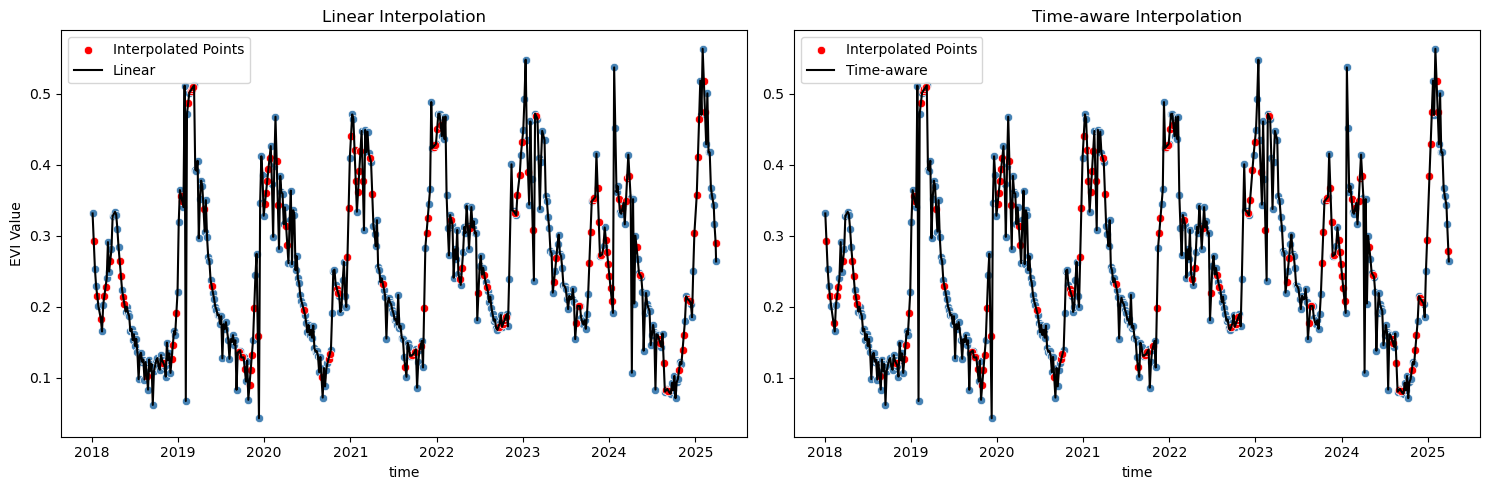

In [ ]:
# Identify points that will be interpolated:
interpolated_pts = evi_sm_df_flt[evi_sm_df_flt.isna()].index

# Linear interpolation - connects points with straight lines
evi_sm_df_flt_intp1 = evi_sm_df_flt.interpolate(method='linear')

# Time-aware interpolation - accounts for actual temporal distances
evi_sm_df_flt_intp2 = evi_sm_df_flt.interpolate(method='time')

# Compare both methods
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x=evi_sm_df_flt.index, y=evi_sm_df_flt.values, color='steelblue', ax=axes[0])
sns.scatterplot(x=interpolated_pts, y=evi_sm_df_flt_intp1[interpolated_pts], color='red', ax=axes[0], label='Interpolated Points')
sns.lineplot(x=evi_sm_df_flt_intp1.index, y=evi_sm_df_flt_intp1.values, color='black', ax=axes[0], label='Linear')
axes[0].set_title('Linear Interpolation')
axes[0].set_ylabel('EVI Value')
axes[0].legend()

sns.scatterplot(x=evi_sm_df_flt.index, y=evi_sm_df_flt.values, color='steelblue', ax=axes[1])
sns.scatterplot(x=interpolated_pts, y=evi_sm_df_flt_intp2[interpolated_pts], color='red', ax=axes[1], label='Interpolated Points')
sns.lineplot(x=evi_sm_df_flt_intp2.index, y=evi_sm_df_flt_intp2.values, color='black', ax=axes[1], label='Time-aware')
axes[1].set_title('Time-aware Interpolation')
axes[1].set_ylabel('')
axes[1].legend()
plt.tight_layout()

Well, both methods seem to result in similar outcomes here, but I'd go with the time-aware interpolation, as it considers the actual time intervals between observations, which is particularly important in time series data where observations may not be evenly spaced.
Of course there are also other standard interpolation methods available in pandas (and other libraries), e.g., polynomial interpolation, spline interpolation, or more advanced methods. The choice of method depends on the specific characteristics of the data and the desired outcome. In this case, I think the time-aware interpolation is good enough and there is no reason to go for something more complex. Let's proceed with fitting a smooth line to the filtered and interpolated data:

## Fitting a smooth line to the time series data

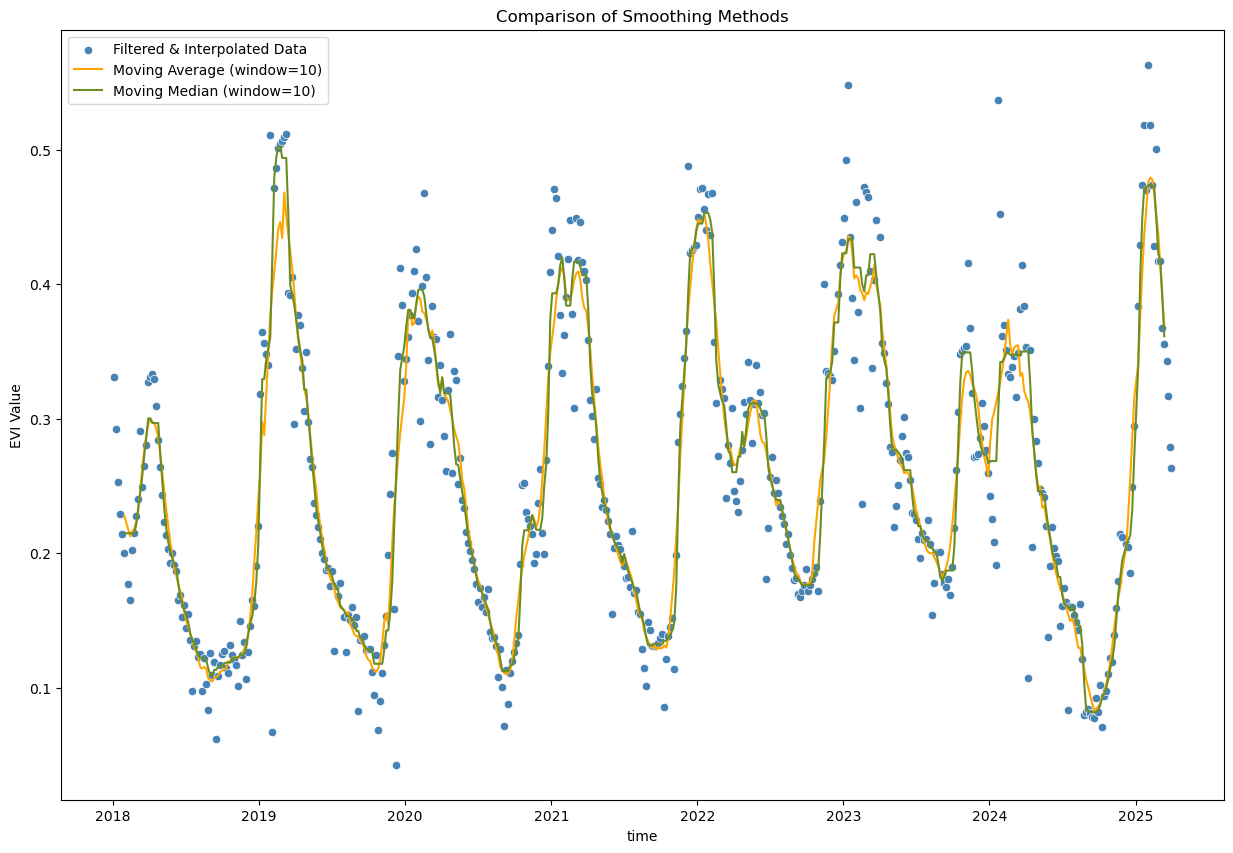

In [404]:
window_size = 10 

# Moving average - simple smoothing
evi_sm_df_flt_intp2_sm1 = evi_sm_df_flt_intp2.rolling(window=window_size, center=True).mean()

# Moving median - alternative simple smoothing
evi_sm_df_flt_intp2_sm2 = evi_sm_df_flt_intp2.rolling(window=window_size, center=True).median()

plt.figure(figsize=(15, 10))
sns.scatterplot(x=evi_sm_df_flt_intp2.index, y=evi_sm_df_flt_intp2.values, color='steelblue', label='Filtered & Interpolated Data')
sns.lineplot(x=evi_sm_df_flt_intp2_sm1.index, y=evi_sm_df_flt_intp2_sm1.values, color='orange', label=f'Moving Average (window={window_size})')
sns.lineplot(x=evi_sm_df_flt_intp2_sm2.index, y=evi_sm_df_flt_intp2_sm2.values, color='olivedrab', label=f'Moving Median (window={window_size})')
plt.title('Comparison of Smoothing Methods')
plt.ylabel('EVI Value')
plt.legend()

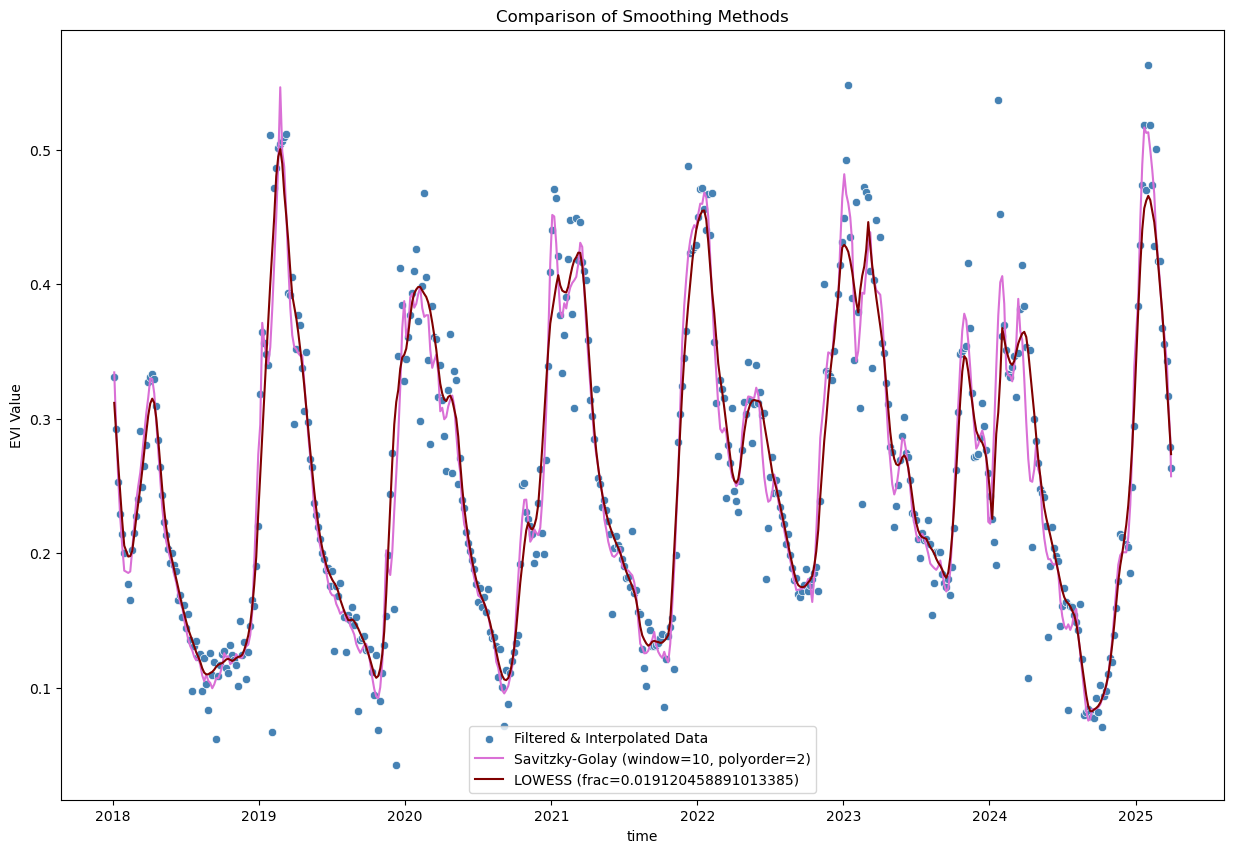

In [ ]:
from scipy.signal import savgol_filter
from statsmodels.nonparametric.smoothers_lowess import lowess

# Savitzky-Golay filter
polyorder = 2
evi_sm_df_flt_intp2_sm3 = pd.Series(
    savgol_filter(evi_sm_df_flt_intp2, window_length=window_size, polyorder=polyorder), index=evi_sm_df_flt_intp2.index
)

# LOWESS smoothing
lowess_frac = window_size / len(evi_sm_df_flt_intp2)  # fraction of data used for each local regression
evi_sm_df_flt_intp2_sm4 = pd.Series(
    lowess(evi_sm_df_flt_intp2, evi_sm_df_flt_intp2.index, return_sorted=False, frac=lowess_frac), index=evi_sm_df_flt_intp2.index
)

plt.figure(figsize=(15, 10))
sns.scatterplot(x=evi_sm_df_flt_intp2.index, y=evi_sm_df_flt_intp2.values, color='steelblue', label='Filtered & Interpolated Data')
sns.lineplot(x=evi_sm_df_flt_intp2_sm3.index, y=evi_sm_df_flt_intp2_sm3.values, color='orchid', label=f'Savitzky-Golay (window={window_size}, polyorder={polyorder})')
sns.lineplot(x=evi_sm_df_flt_intp2_sm4.index, y=evi_sm_df_flt_intp2_sm4.values, color='maroon', label=f'LOWESS (frac={lowess_frac})')
plt.title('Comparison of Smoothing Methods')
plt.ylabel('EVI Value')
plt.legend()

## When to Use Which Method?

**Interpolation vs. Smoothing:**
- **Interpolation**: Use to fill gaps in your time series
- **Smoothing**: Use to reduce noise in the overall signal (applied after interpolation)

**Interpolation Method Selection:**
- **Linear**: Simple interpolation that connects points with straight lines
  - Fast and straightforward
  - Doesn't account for irregular temporal spacing
- **Time-aware**: Accounts for actual temporal distances between observations
  - More appropriate for irregular sampling (e.g. due to cloud masking)
  - Better preserves temporal dynamics
- **Gap limiting**: Always use `limit` parameter to avoid interpolating across large gaps
  - Rule of thumb: Don't interpolate across more than 2-3 missing observations
  - Consider phenological cycles: don't interpolate across seasonal transitions

**Note:** Polynomial and spline interpolation methods are also available in pandas (`.interpolate(method='polynomial', order=2)` or `.interpolate(method='spline', order=3)`), but can create unrealistic oscillations, especially near gaps or data boundaries.

**Smoothing Method Selection:**
- **Window size**: Choose based on expected temporal dynamics of your variable
  - E.g., for vegetation indices with Sentinel-2 data (5-day revisit), a window of ~35-55 days (7-11 observations) is often appropriate

- **Moving Average**: Simple arithmetic mean over a rolling window
  - Easy to understand and implement
  - Reduces amplitude of peaks
  - Good for initial exploration
  
- **Moving Median**: Uses median instead of mean in rolling window
  - More robust to remaining outliers than moving average
  - Also easy to implement and understand
  - Better preservation of peak values than moving average
  - Slightly more computational cost
  
- **Savitzky-Golay**: Fits local polynomials to smooth the data
  - Excellent for vegetation indices - very popular in remote sensing
  - Preserves peaks and trends better than moving average
  
- **LOWESS** (Locally Weighted Scatterplot Smoothing): Non-parametric regression method
  - Very flexible, adapts to local data structure
  - Good for complex seasonal patterns
  - `frac` parameter controls smoothness (smaller = less smooth)
  - More computationally intensive
  - Can be sensitive to parameter choices

**Important Considerations:**
1. **Always inspect visually** - no single method is perfect for all cases
2. **Window size matters** - larger windows = smoother curves but may lose important details
3. **Preserve seasonal dynamics** - don't over-smooth; you want to retain phenological patterns
4. **Document your choices** - make processing reproducible for your analysis
5. **Consider your analysis goals**: - e.g., trend analysis, phenology metrics, anomaly detection, etc.
6. **Validate when possible** - compare with visual inspection of original satellite images, ground truth data, or known phenological events